# Image augmention

When we design an algorithm to classify objects in images, we have to deal with a lot of irrelevant information.  We really only want our algorithm to determine if an object is present in the image or not. The size of the object doesn't matter, neither does the angle, or if we move it all the way to the right side of the image. It is still an image with an object. 

In other words, we can say that we want our algorithm to learn an invariant representation of the image. We don't want our model to change its prediction based on the size of the object.  This is called **scale variance**. Likewise, we don't want the angle of the object to matter. This is called **rotation invariance**. If we shift the image a little to the left or to the right, well, it's still or object, and this is called **translation invariance**. 

CNNs do have some built-in translation invariance. To see that, we need to first recall how we calculate max-pooling layers. Remember that at each window location, we took the maximum of the pixels contained in the window. This maximum value can occur anywhere within the window. The value of the maxpooling node would be the same if we translated the image a little ot the left, to the right, up, down, as long as the maximum value stays within the window. The effect of applying many max pooling layers in a sequence each one following a convolutional layer, is that we could translate the object quite far to the left, to the top of the image, to the bottom of the image, and still our network will be able to make sense of it all. This is truly a non-trivial problem. Recall that the computer only sees a matrix of pixels. Transforming an object's scale, rotation, or position in the image has a huge effect on the pixel values. We as humans can see the difference in images quite clearly, but how do we think we could do if we just given the corresponding array of numbers? 

Thankfully, there is a technique that works well for making our algorithms more statistically invariant, but it will feel a little bit like cheating. The idea is this, if we want our CNN to be rotation invariant, then we can just add some images to our training set created by doing random rotations on our training images. If we want more translation invariance, we can also just add new images created by doing random translations of our training images. When we do this, we say that we have expanded the training set by augmenting the data. 

Data augmentation will also help us to avoid overfitting. This is because the model is seeing many new images. Thus, it should be better at generalizing and we should gt better performance on the test dataset. 

Let's apply those concepts to the CFR10 dataset and see how can improve our test accuracy. 

---
## Load and Augment the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

#### Augmentation

In this cell, we perform some simple [data augmentation](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced) by randomly flipping and rotating the given image data. We do this by defining a torchvision `transform`, and you can learn about all the transforms that are used to pre-process and augment data, [here](https://pytorch.org/docs/stable/torchvision/transforms.html).

#### TODO: Look at the [transformation documentation](https://pytorch.org/docs/stable/torchvision/transforms.html); add more augmentation transforms, and see how your model performs.

This type of data augmentation should add some positional variety to these images, so that when we train a model on this data, it will be robust in the face of geometric changes (i.e. it will recognize a ship, no matter which direction it is facing). It's recommended that you choose one or two transforms.

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

CUDA is not available.  Training on CPU ...
Files already downloaded and verified
Files already downloaded and verified


### Visualize a Batch of Training Data

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

/Users/mb78200/opt/anaconda3/envs/my_p3_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


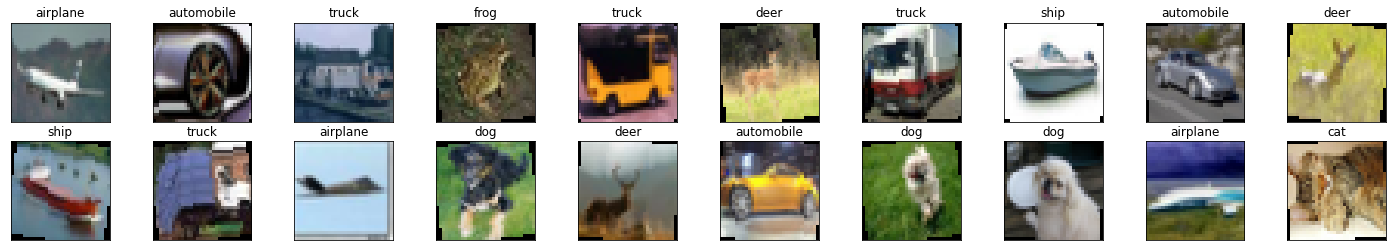

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

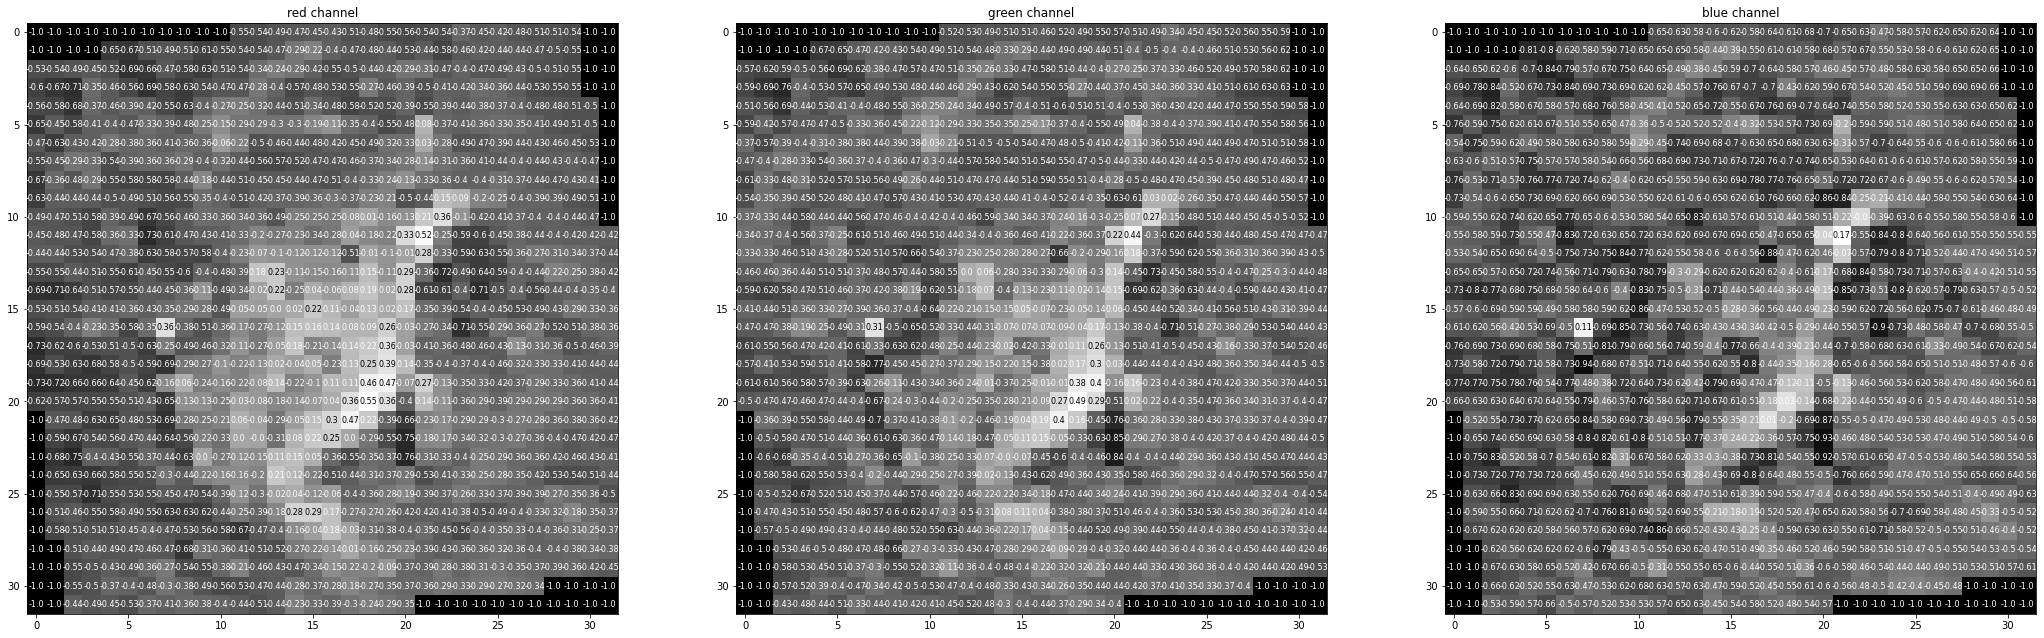

In [5]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)


In [6]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [7]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [8]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.123135 	Validation Loss: 1.865023
Validation loss decreased (inf --> 1.865023).  Saving model ...
Epoch: 2 	Training Loss: 1.722178 	Validation Loss: 1.559918
Validation loss decreased (1.865023 --> 1.559918).  Saving model ...
Epoch: 3 	Training Loss: 1.525629 	Validation Loss: 1.435693
Validation loss decreased (1.559918 --> 1.435693).  Saving model ...
Epoch: 4 	Training Loss: 1.418565 	Validation Loss: 1.341346
Validation loss decreased (1.435693 --> 1.341346).  Saving model ...
Epoch: 5 	Training Loss: 1.334287 	Validation Loss: 1.242039
Validation loss decreased (1.341346 --> 1.242039).  Saving model ...
Epoch: 6 	Training Loss: 1.253455 	Validation Loss: 1.169979
Validation loss decreased (1.242039 --> 1.169979).  Saving model ...
Epoch: 7 	Training Loss: 1.191524 	Validation Loss: 1.103684
Validation loss decreased (1.169979 --> 1.103684).  Saving model ...
Epoch: 8 	Training Loss: 1.138453 	Validation Loss: 1.054901
Validation loss decreased (1.10368

In [9]:
model.load_state_dict(torch.load('model_augmented.pt'))

<All keys matched successfully>

In [10]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.690095

Test Accuracy of airplane: 82% (820/1000)
Test Accuracy of automobile: 89% (891/1000)
Test Accuracy of  bird: 63% (632/1000)
Test Accuracy of   cat: 63% (634/1000)
Test Accuracy of  deer: 68% (688/1000)
Test Accuracy of   dog: 64% (647/1000)
Test Accuracy of  frog: 83% (834/1000)
Test Accuracy of horse: 78% (783/1000)
Test Accuracy of  ship: 84% (840/1000)
Test Accuracy of truck: 79% (792/1000)

Test Accuracy (Overall): 75% (7561/10000)


/Users/mb78200/opt/anaconda3/envs/my_p3_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


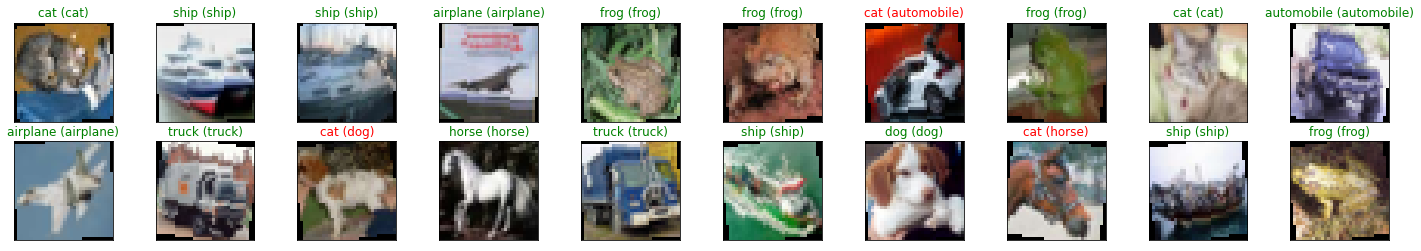

In [11]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

# Groundbreaking CNN Architectures

ImageNet is a database of over 10 million hand labeled images, drawn from 1000 different image categories. Since 2010, the ImageNet project has held the ImageNet Large Scale Visual Recognition Competition, an annual competition where teams try to build the best CNN for object recognition and classification. 

The first breakout was in 2012, the network called AlexNet, was developed by a team at the University of Toronto. Using the best GPU's available in 2012, the AlexNet team trained the network in about a week. AlexNet pioneered the use of the ReLU activation function, and dropout as a technique for avoiding overfitting. 

<img src="assets/AlexNet.png">

In 2014, two different groups nearly tied in the ImageNet competition. One of those networks was called VGGNet, often referred to as just VGG, and it came from the Visual Geometry Group at Oxford University. VGG has two versions termed VGG16, and VGG19, with 16 and 19 total layers respectively. Both versions have a simple and elegant architecture, which is just a long sequence of three by three convolutions, broken up by two by two pooling layers, and finished with three fully connected layers. VGG pioneered the exclusive use of small three by three convolution windows, to contrast AlexNets much larger 11 by 11 windows. 

<img src="assets/VGGArchitecture.png">

In 2015, the ImageNet winner was a network from Microsoft Research called ResNet. ResNet is like VGG and note the same structure is repeated again and again, or layer after layer. Also like VGG, ResNet has different versions that vary in their number of layers. The largest having a groundbreaking 152 layers. Previous researchers tried to make their CNNs this depth, but the ran into a problem where as they were adding layers, performance increased up to a point, after which performance quickly declined. This is partially due to what's known as the vanishing gradient's problem, which arises when we go to the train the network through backpropagation. The main idea is that the gradient signal has to be pushed through the entire network. The deeper the network becomes, the more likely that the signal gets weakend before it gets where it needs to go. The ResNet team added connections to their very deep CNN that skip layers. So the gradient signal has a shorter route to travel. ResNet achieves superhuman performance in classifying images in the ImageNet database.

<img src="assets/ResNetArchitecture.png">

## Aditional resources:

- Check out the [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) paper!
- Read more about [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) here.
- The [ResNet](https://arxiv.org/pdf/1512.03385v1.pdf) paper can be found here.
- Here's the Keras [documentation](https://keras.io/applications/) for accessing some famous CNN architectures.
- Read this [detailed treatment](http://neuralnetworksanddeeplearning.com/chap5.html) of the vanishing gradients problem.
- Here's a GitHub [repository](https://github.com/jcjohnson/cnn-benchmarks) containing benchmarks for different CNN architectures.
- Visit the [ImageNet Large Scale Visual Recognition Competition (ILSVRC)](http://www.image-net.org/challenges/LSVRC/) website.

# Visualizing CNNs

We have seen that CNNs achieve state-of-the-art and sometimes superhuman performance in object classification tasks. We have explored some techniques for building CNN architectures, and we have gotten some good performance on toy datasets. But at the end of the day, we don't really have a strong understanding of how these CNNs discover patterns in raw image pixels. If we have already taken the time to train our own CNNs, you have noticed that some architectures work while some just don't. And if it is not clear to us why that's the case, it is probabily not truly clear to the experts either. 

In previous notebooks, we mentioned visualizing the activation maps and convolutional layers as one technique for digging deeper into understanding how a CNN is working. There are many implementations of this online. You can look at this resources:

- Check out this [demonstration](https://aiexperiments.withgoogle.com/what-neural-nets-see) of a cool [OpenFrameworks](http://openframeworks.cc/) app that visualizes CNNs in real-time, from user-supplied video!
- Here's a [demonstration](https://www.youtube.com/watch?v=AgkfIQ4IGaM&t=78s) of another visualization tool for CNNs. If you'd like to learn more about how these visualizations are made, check out this [video](https://www.youtube.com/watch?v=ghEmQSxT6tw&t=5s).

Another technique designed for understanding CNNs involves taking the filters from our convolutional layers and constructing images that maximize their activations. You can start with an image containing random noise and then gradually amend the pixels, and each step changing them to values that make the filter more highly activated. When we do this, we will notice that the first three layers are pretty general. The first layer might include color or edge detectors, where the second layer detects circles or stripes. The filters later in the network are activated by much more complicated patterns. Researchers at Google got creative with this. They designed a technique called deep dreams where they replace the starting image with a picture. Say we have a picture of tree, but we can use a picture of anything here. Then, we could investigate one of the more interesting filters, maybe one that looks like it is used for detecting a building. When we follow the same technique where the only thing we have changed is the starting array of pixels, we end up creating an image that looks like some sort of tree or building hybrid.

Read this [Keras blog post](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) on visualizing how CNNs see the world. In this post, you can find an accessible introduction to Deep Dreams, along with code for writing your own deep dreams in Keras. When you've read that:

- Also check out this [music video](https://www.youtube.com/watch?v=XatXy6ZhKZw) that makes use of Deep Dreams (look at 3:15-3:40)!
- Create your own Deep Dreams (without writing any code!) using this [website](https://deepdreamgenerator.com/).

There are many other techniques for visualizing what a CNN learns. We have only scratched the surface with this, but we definitely encourage to explore more in this area. The idea is that if we can understand more of what a CNN learns, we can help it to perform even better. 

### More resources:

- Here's a [section](http://cs231n.github.io/understanding-cnn/) from the Stanford's CS231n course on visualizing what CNNs learn.
- If you'd like to read more about interpretability of CNNs:

- - Here's an [article](https://blog.openai.com/adversarial-example-research/) that details some dangers from using deep learning models (that are not yet interpretable) in real-world applications.
- - There's a lot of active research in this area. [These authors](https://arxiv.org/abs/1611.03530) recently made a step in the right direction.


# Visualizing CNNs example


Let's look at an example CNN to see how it works in action. 

The CNN we will look at is trained on ImageNet as described in [this paper](hhttps://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf) by Zeileer and Fergus. In the images below (from the same paper), we will see what each lauer in this networks detects and see how each layer detects more and more complex ideas. 

<img src="assets/layer-1-grid.png">
Example patterns that cause activations in the first layer of the network. These range from simple diagonal lines (top left) to green blobs (botton middle).

The images above are from Matthew Zeiler and Rob Fergus' [deep visualization toolbox](https://www.youtube.com/watch?v=ghEmQSxT6tw), which lets us visualize what each layer in a CNN focuses on.

Each image in the above grid represents a pattern that causes the neurons in the first layer to activate - in other words, they are patterns that the first layer recognizes. The top left image shows a -45 degree line, while the middle top square shows a +45 degree line. These squares are shown below again for reference.

<img src="assets/diagonal-line-1.png">
As visualized, the first layer o the CNN can recognize a -45 degree lines.

<img src="assets/diagonal-line-2.png">
The first layer of the CNN is also able to recognize a +45 degree lines.

Let's now see some example images that cause such activations. The below grid of images all activated the -45 degree line. Notice how they are all selected despite the fact that they have different colors, gradients, and patterns.

<img src="assets/grid-layer-1.png">
Example patches that activate the -45 degree line detector in the first layer.

So, the first layer of our CNN clearly picks out very simple shapes and patterns like lines and blobs.

## Layer 2

<img src="assets/Layer2.png">
A visualization of the second layer in the CNN. Notice how we are picking up more complex ideas like circles and stripes. The gray grid on the left represents how this layer of the CNN activates (or "what it sees") based on the corresponding images from the grid on the right.

The second layer of the CNN captures complex ideas.

As you see in the image above, the second layer of the CNN recognizes circles (second row, second column), stripes (first row, second column), and rectangles (bottom right).

**The CNN learns to do this on its own**. There is no special instruction for the CNN to focus on more complex objects in deeper layers. That's just how it normally works out when you feed training data into a CNN.

## Layer 3

<img src="assets/Layer3.png">
A visualization of the third layer in the CNN. The gray grid on the left represent how this layer of the CNN activates (or "what it sees") based on the corresponding images from the grid on the right.

The third layer picks out complex combinations of features from the second layer. These includes things like grids, and honeycombs (top left), wheels (second row, second column), and even faces (third row, third column).

We will skip layer 4, which continues this progression, and jump right to the fifth and final layer of this CNN.

## Layer 5

<img src="assets/Layer5.png">
A visualization of the fifth and final layer of the CNN. The gray grid on the left represents how this layer of the CNN activates (or "what it sees") based on the corresponding images from the grid on the right.

The last layer picks out the highest order ideas that we care about for classification, like dog faces, bird faces, and bicycles.

# Summary of CNNs

So far we have seen how to create two kids of neural networks for images classification, and we have seen how convolutional neural networks follow a series of steps to classify an image. Just to recap, a CNN first takes in an input image, then puts that image through several convolutional and pooling layers. The result is a set of feature maps reduced in size from the original image that through a training process have learned to distill information about the content in the original image. We then flatten these maps, creating a feature vector that we can then pass to a series of fully-connected linear layers to produce a probability distribution of class scores. From this, we can extract the predicted class for the input image. 

On short, an image comes in and a predicted class label comes out. We have learned the foundational concepts behind CNN's and in later notebooks we will learn about techniques that leverage existing architectures and even more techniques for improving the performance of a model. We should also know that CNN's are not restricted to the task of image classification. They can be applied to any task with a fixed number of outputs such as regression tasks that look at points on a face or detect human poses. The applications of CNNs are very far-reaching and after seeing just a few, we hope to share our exciting to learn even more.